In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8449495135818824246
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 6772842168
locality {
  bus_id: 1
}
incarnation: 11171466564978200449
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 6772842168
locality {
  bus_id: 1
}
incarnation: 10073565492017992476
physical_device_desc: "device: 1, name: GeForce GTX 1070, pci bus id: 0000:02:00.0"
]


In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

Using TensorFlow backend.


In [2]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

# Resize the images to 512x512

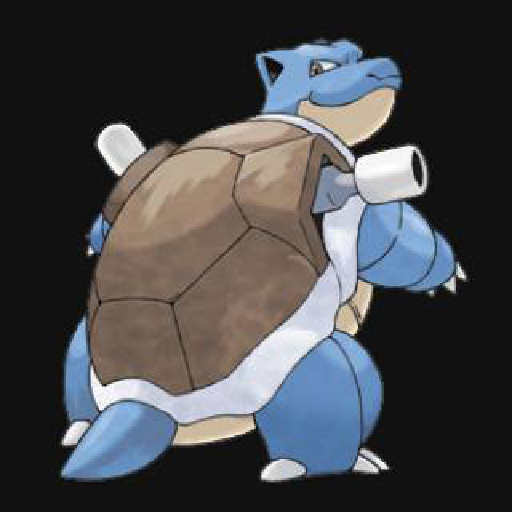

In [3]:
content_image=Image.open('blastoise.jpg')
w, h = content_image.size
content_image=content_image.resize((512,512))
content_image

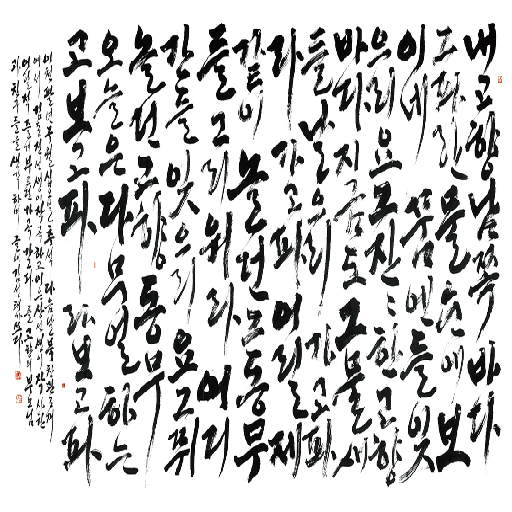

In [4]:
style_image= Image.open('hangeul.jpg')
style_image=style_image.resize((512,512))
style_image

# Add dimension to later concatenate the representation of these two images into a common data structure

In [5]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
#content_array=np.array(content_array).copy()

In [6]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


# Subtract the mean RGB value previously computed on ImageNet 

# Flip from RGB to BGR to match ordering used in VGG

In [7]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

In [8]:
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]
style_array.shape

(1, 512, 512, 3)

# Create variables

In [9]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

# Concatenate into a single tensor

In [10]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

# Load VGG16 pretrained model

In [11]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

In [12]:
layers=dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <t

# Set weights of loss functions

In [13]:
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

# Initialize total loss to 0

In [14]:
loss=backend.variable(0.)

# Content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images

In [15]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [16]:
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

# Style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images

In [17]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [18]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [19]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [20]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

# Total Variation Loss is a regularization term for spatial smoothness

In [21]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

# Define the gradients

In [22]:
grads = backend.gradients(loss, combination_image)

# Optimize using Limited-memory BFGS algorithm

In [23]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [24]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [25]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [26]:
evaluator=Evaluator()

In [27]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

In [28]:
%%javascript
// Source - https://stackoverflow.com/a/23395136

Jupyter.beep = () => {
    var snd = new Audio("data:audio/wav;base64,//uQRAAAAWMSLwUIYAAsYkXgoQwAEaYLWfkWgAI0wWs/ItAAAGDgYtAgAyN+QWaAAihwMWm4G8QQRDiMcCBcH3Cc+CDv/7xA4Tvh9Rz/y8QADBwMWgQAZG/ILNAARQ4GLTcDeIIIhxGOBAuD7hOfBB3/94gcJ3w+o5/5eIAIAAAVwWgQAVQ2ORaIQwEMAJiDg95G4nQL7mQVWI6GwRcfsZAcsKkJvxgxEjzFUgfHoSQ9Qq7KNwqHwuB13MA4a1q/DmBrHgPcmjiGoh//EwC5nGPEmS4RcfkVKOhJf+WOgoxJclFz3kgn//dBA+ya1GhurNn8zb//9NNutNuhz31f////9vt///z+IdAEAAAK4LQIAKobHItEIYCGAExBwe8jcToF9zIKrEdDYIuP2MgOWFSE34wYiR5iqQPj0JIeoVdlG4VD4XA67mAcNa1fhzA1jwHuTRxDUQ//iYBczjHiTJcIuPyKlHQkv/LHQUYkuSi57yQT//uggfZNajQ3Vmz+Zt//+mm3Wm3Q576v////+32///5/EOgAAADVghQAAAAA//uQZAUAB1WI0PZugAAAAAoQwAAAEk3nRd2qAAAAACiDgAAAAAAABCqEEQRLCgwpBGMlJkIz8jKhGvj4k6jzRnqasNKIeoh5gI7BJaC1A1AoNBjJgbyApVS4IDlZgDU5WUAxEKDNmmALHzZp0Fkz1FMTmGFl1FMEyodIavcCAUHDWrKAIA4aa2oCgILEBupZgHvAhEBcZ6joQBxS76AgccrFlczBvKLC0QI2cBoCFvfTDAo7eoOQInqDPBtvrDEZBNYN5xwNwxQRfw8ZQ5wQVLvO8OYU+mHvFLlDh05Mdg7BT6YrRPpCBznMB2r//xKJjyyOh+cImr2/4doscwD6neZjuZR4AgAABYAAAABy1xcdQtxYBYYZdifkUDgzzXaXn98Z0oi9ILU5mBjFANmRwlVJ3/6jYDAmxaiDG3/6xjQQCCKkRb/6kg/wW+kSJ5//rLobkLSiKmqP/0ikJuDaSaSf/6JiLYLEYnW/+kXg1WRVJL/9EmQ1YZIsv/6Qzwy5qk7/+tEU0nkls3/zIUMPKNX/6yZLf+kFgAfgGyLFAUwY//uQZAUABcd5UiNPVXAAAApAAAAAE0VZQKw9ISAAACgAAAAAVQIygIElVrFkBS+Jhi+EAuu+lKAkYUEIsmEAEoMeDmCETMvfSHTGkF5RWH7kz/ESHWPAq/kcCRhqBtMdokPdM7vil7RG98A2sc7zO6ZvTdM7pmOUAZTnJW+NXxqmd41dqJ6mLTXxrPpnV8avaIf5SvL7pndPvPpndJR9Kuu8fePvuiuhorgWjp7Mf/PRjxcFCPDkW31srioCExivv9lcwKEaHsf/7ow2Fl1T/9RkXgEhYElAoCLFtMArxwivDJJ+bR1HTKJdlEoTELCIqgEwVGSQ+hIm0NbK8WXcTEI0UPoa2NbG4y2K00JEWbZavJXkYaqo9CRHS55FcZTjKEk3NKoCYUnSQ0rWxrZbFKbKIhOKPZe1cJKzZSaQrIyULHDZmV5K4xySsDRKWOruanGtjLJXFEmwaIbDLX0hIPBUQPVFVkQkDoUNfSoDgQGKPekoxeGzA4DUvnn4bxzcZrtJyipKfPNy5w+9lnXwgqsiyHNeSVpemw4bWb9psYeq//uQZBoABQt4yMVxYAIAAAkQoAAAHvYpL5m6AAgAACXDAAAAD59jblTirQe9upFsmZbpMudy7Lz1X1DYsxOOSWpfPqNX2WqktK0DMvuGwlbNj44TleLPQ+Gsfb+GOWOKJoIrWb3cIMeeON6lz2umTqMXV8Mj30yWPpjoSa9ujK8SyeJP5y5mOW1D6hvLepeveEAEDo0mgCRClOEgANv3B9a6fikgUSu/DmAMATrGx7nng5p5iimPNZsfQLYB2sDLIkzRKZOHGAaUyDcpFBSLG9MCQALgAIgQs2YunOszLSAyQYPVC2YdGGeHD2dTdJk1pAHGAWDjnkcLKFymS3RQZTInzySoBwMG0QueC3gMsCEYxUqlrcxK6k1LQQcsmyYeQPdC2YfuGPASCBkcVMQQqpVJshui1tkXQJQV0OXGAZMXSOEEBRirXbVRQW7ugq7IM7rPWSZyDlM3IuNEkxzCOJ0ny2ThNkyRai1b6ev//3dzNGzNb//4uAvHT5sURcZCFcuKLhOFs8mLAAEAt4UWAAIABAAAAAB4qbHo0tIjVkUU//uQZAwABfSFz3ZqQAAAAAngwAAAE1HjMp2qAAAAACZDgAAAD5UkTE1UgZEUExqYynN1qZvqIOREEFmBcJQkwdxiFtw0qEOkGYfRDifBui9MQg4QAHAqWtAWHoCxu1Yf4VfWLPIM2mHDFsbQEVGwyqQoQcwnfHeIkNt9YnkiaS1oizycqJrx4KOQjahZxWbcZgztj2c49nKmkId44S71j0c8eV9yDK6uPRzx5X18eDvjvQ6yKo9ZSS6l//8elePK/Lf//IInrOF/FvDoADYAGBMGb7FtErm5MXMlmPAJQVgWta7Zx2go+8xJ0UiCb8LHHdftWyLJE0QIAIsI+UbXu67dZMjmgDGCGl1H+vpF4NSDckSIkk7Vd+sxEhBQMRU8j/12UIRhzSaUdQ+rQU5kGeFxm+hb1oh6pWWmv3uvmReDl0UnvtapVaIzo1jZbf/pD6ElLqSX+rUmOQNpJFa/r+sa4e/pBlAABoAAAAA3CUgShLdGIxsY7AUABPRrgCABdDuQ5GC7DqPQCgbbJUAoRSUj+NIEig0YfyWUho1VBBBA//uQZB4ABZx5zfMakeAAAAmwAAAAF5F3P0w9GtAAACfAAAAAwLhMDmAYWMgVEG1U0FIGCBgXBXAtfMH10000EEEEEECUBYln03TTTdNBDZopopYvrTTdNa325mImNg3TTPV9q3pmY0xoO6bv3r00y+IDGid/9aaaZTGMuj9mpu9Mpio1dXrr5HERTZSmqU36A3CumzN/9Robv/Xx4v9ijkSRSNLQhAWumap82WRSBUqXStV/YcS+XVLnSS+WLDroqArFkMEsAS+eWmrUzrO0oEmE40RlMZ5+ODIkAyKAGUwZ3mVKmcamcJnMW26MRPgUw6j+LkhyHGVGYjSUUKNpuJUQoOIAyDvEyG8S5yfK6dhZc0Tx1KI/gviKL6qvvFs1+bWtaz58uUNnryq6kt5RzOCkPWlVqVX2a/EEBUdU1KrXLf40GoiiFXK///qpoiDXrOgqDR38JB0bw7SoL+ZB9o1RCkQjQ2CBYZKd/+VJxZRRZlqSkKiws0WFxUyCwsKiMy7hUVFhIaCrNQsKkTIsLivwKKigsj8XYlwt/WKi2N4d//uQRCSAAjURNIHpMZBGYiaQPSYyAAABLAAAAAAAACWAAAAApUF/Mg+0aohSIRobBAsMlO//Kk4soosy1JSFRYWaLC4qZBYWFRGZdwqKiwkNBVmoWFSJkWFxX4FFRQWR+LsS4W/rFRb/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////VEFHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAU291bmRib3kuZGUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMjAwNGh0dHA6Ly93d3cuc291bmRib3kuZGUAAAAAAAAAACU=");  
    snd.play();
}

<IPython.core.display.Javascript object>

In [29]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
9.93989e+11
Iteration 0 completed in 10s
Start of iteration 1
5.922e+11
Iteration 1 completed in 6s
Start of iteration 2
4.78356e+11
Iteration 2 completed in 6s
Start of iteration 3
4.31905e+11
Iteration 3 completed in 6s
Start of iteration 4
4.08354e+11
Iteration 4 completed in 6s
Start of iteration 5
3.9378e+11
Iteration 5 completed in 6s
Start of iteration 6
3.83489e+11
Iteration 6 completed in 6s
Start of iteration 7
3.75644e+11
Iteration 7 completed in 6s
Start of iteration 8
3.69717e+11
Iteration 8 completed in 6s
Start of iteration 9
3.65198e+11
Iteration 9 completed in 6s


In [30]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

# Reverse transformations to original image dimensions

In [31]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')


In [32]:
from PIL import Image
import scipy.misc

im = Image.fromarray(x)
x2=im.resize((w,h))
scipy.misc.imsave('outfile.jpg', x2)

C:\Users\Bob\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


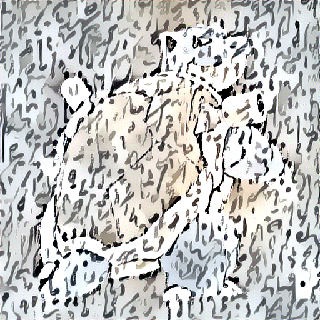

In [33]:
x2